In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

## Загрузка данных

In [63]:
data = 'processing_rides.csv'
df_rides = pd.read_csv(data)

df_weather = pd.read_csv('weather_processed.csv', parse_dates=['datetime'])
print(f"Данные загружены.")

Данные загружены.


## Приведение столбцов времени к формату datetime

In [64]:
df_rides['start_date'] = pd.to_datetime(df_rides['start_date'])
df_rides['end_date'] = pd.to_datetime(df_rides['end_date'])
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

df_rides.dtypes[['start_date', 'end_date']]

start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

## КОНСТАНТЫ

In [65]:
COST_START = 30
PROMO_START_TIME = 6
PROMO_END_TIME = 10

# 1. Итоговая стоимость поездок

## Расчет итоговой стоимости

In [66]:
# подготовка таблицы со стоимостью
data = {
    'Пн-Пт': [3, 4, 5, 6, 5],
    'Сб-Вс': [3, 4, 6, 7, 6]
}

time_intervals = [
    '01:00-06:00',
    '06:00-10:00',
    '10:00-16:00',
    '16:00-22:00',
    '22:00-01:00'
]

df_dynamic_costs = pd.DataFrame(data, index=time_intervals)

# Создаем функцию, которая вычисляет интервал времени
def get_cost_per_minute(start_date):
    hour = int(start_date.hour)
    day_of_week = int(start_date.dayofweek)
    day_type = 'Пн-Пт' if day_of_week < 5 else "Сб-Вс"

    time_interval = '22:00-01:00'
    if hour >= 1 and hour < 6:
        time_interval = '01:00-06:00'
    elif hour >= 6 and hour < 10:
        time_interval = '06:00-10:00'
    elif hour >= 10 and hour < 16:
        time_interval = '10:00-16:00'
    elif hour >= 16 and hour < 22:
        time_interval = '16:00-22:00'

    cost_per_min = df_dynamic_costs.loc[time_interval, day_type]
    return cost_per_min


# Итоговая стоимость = старт (30 руб.) + длительность (мин) * стоимость минуты (руб./мин)
# По понедельникам с 6:00 до 10:00 акция «Бесплатный старт» по промо-коду

def calculate_cost(row):
    # переводим длительность в минуты с округлением вверх (если проехали хоть лишнюю секунду платим за всю минуту)
    duration_minutes = np.ceil(row['duration'] / 60)

    # получаем стоимость за минуту
    cost_per_minute = get_cost_per_minute(row['start_date'])

    #считаем цену без промокода
    total_cost = cost_per_minute * duration_minutes + COST_START

    # определяем день недели
    day_of_week = int(row['start_date'].dayofweek)

    # получаем час поездки
    hour = int(row['start_date'].hour)

    # если промокод активен вычитаем стоимость старта
    if day_of_week == 0 and (hour >= PROMO_START_TIME and hour < PROMO_END_TIME) and row['promo'] == 1:
        total_cost -= COST_START

    return total_cost


df_rides['cost'] = df_rides.apply(calculate_cost, axis=1)

df_rides.head(10)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,cost
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.000000,0,1422.0,126.0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.000000,0,1705.0,146.0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.000000,0,2299.0,186.0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.000000,0,1909.0,158.0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.000000,0,1840.0,154.0
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-Восточный,Западная,Ленинский,4879.000000,0,2387.0,190.0
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846.000000,0,649.0,74.0
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,Западная,Ленинский,3133.000000,0,1250.0,114.0
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,Ленинский,Озерная,Юго-Восточный,2764.434176,0,1042.0,102.0
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,Ленинский,Чкалова,Юго-Восточный,5263.000000,0,2048.0,170.0


## Количество поездок в разные дни и их стоимость

In [67]:
print("Средняя стоимость поездки:", round(df_rides['cost'].mean(), 2))
print("Медианная стоимость поездки:", df_rides['cost'].median())
print("Минимальня стоимость поездки:", df_rides['cost'].min())
print("Максимальная стоимость поездки:", df_rides['cost'].max())
print()

# Копируем наш датафрейм чтобы случайно не испортить
df = df_rides.copy()

# Приводим даты к datetime
df['start_datetime'] = pd.to_datetime(df['start_date'])
df['end_datetime'] = pd.to_datetime(df['end_date'])

# День недели (Пн = 0)
df['weekday'] = df['start_datetime'].dt.weekday

# Час начала поездки
df['hour'] = df['start_datetime'].dt.hour

# Дата (без времени) — нужна для агрегации по дням
df['date'] = df['start_datetime'].dt.date


# 2. Формируем сравнимые группы
is_monday = df['weekday'] == 0
is_morning = df['hour'].between(6, 9)

df['group'] = 'other'

# Поездки с акцией
df.loc[
    is_monday & is_morning & (df['promo'] == 1),
    'group'
] = 'promo'

# Поездки без акции в те же дни и часы
df.loc[
    is_monday & is_morning & (df['promo'] == 0),
    'group'
] = 'no_promo_monday'


# 3. Считаем спрос (поездки в день)

daily_rides = (
    df[df['group'].isin(['promo', 'no_promo_monday'])]
    .groupby(['date', 'group'])
    .size()
    .reset_index(name='rides')
)

# Среднее количество поездок в день
avg_rides = daily_rides.groupby('group')['rides'].mean()

avg_promo = avg_rides['promo']
avg_no_promo = avg_rides['no_promo_monday']

incremental_rides = avg_promo - avg_no_promo


print('СПРОС')
print(f'Среднее число поездок в день (с акцией): {avg_promo:.2f}')
print(f'Среднее число поездок в день (без акции): {avg_no_promo:.2f}')
print(f'Дополнительные поездки за счёт акции: {incremental_rides:.2f}\n')

if incremental_rides > 0:
    print("Акция стимулирует спрос")

# 4. Доход от дополнительных поездок
# Средний доход за поездку БЕЗ стартового платежа
avg_minute_revenue = (
    df[df['group'] == 'promo']['cost'].mean() - 30
)

incremental_revenue = incremental_rides * avg_minute_revenue


print('=== ВЫРУЧКА ===')
print(f'Средний доход от минут (без старта): {avg_minute_revenue:.2f} ₽')
print(f'Дополнительная выручка в день из-за акции: {incremental_revenue:.2f} ₽\n')


# 5. Издержки акции

# Издержки считаем ТОЛЬКО для дополнительных поездок
promo_costs = incremental_rides * 30


print('ИЗДЕРЖКИ')
print(f'Стоимость бесплатного старта: 30 ₽')
print(f'Издержки акции в день: {promo_costs:.2f} ₽\n')


# 6. Финансовый результат
profit = incremental_revenue - promo_costs

print('ИТОГ')
print(f'Прибыль / убыток акции в день: {profit:.2f} ₽')

if profit > 0:
    print('Акция ОКУПАЕТСЯ')
else:
    print('Акция НЕ окупается')

Средняя стоимость поездки: 181.3
Медианная стоимость поездки: 170.0
Минимальня стоимость поездки: 24.0
Максимальная стоимость поездки: 625.0

СПРОС
Среднее число поездок в день (с акцией): 127.40
Среднее число поездок в день (без акции): 50.93
Дополнительные поездки за счёт акции: 76.47

Акция стимулирует спрос
=== ВЫРУЧКА ===
Средний доход от минут (без старта): 70.72 ₽
Дополнительная выручка в день из-за акции: 5407.73 ₽

ИЗДЕРЖКИ
Стоимость бесплатного старта: 30 ₽
Издержки акции в день: 2294.00 ₽

ИТОГ
Прибыль / убыток акции в день: 3113.73 ₽
Акция ОКУПАЕТСЯ


## Визуализация расчетов

### Количество всех поездок

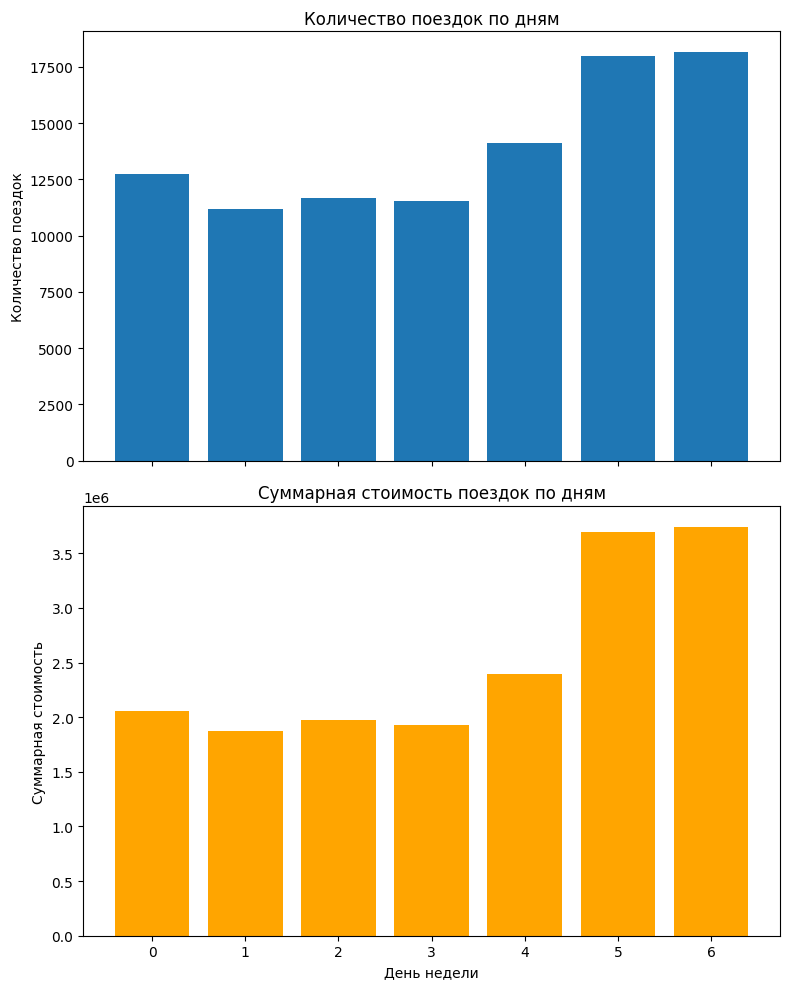

In [68]:
rides = df.groupby('weekday').size().reset_index(name='rides_count')
rides_amount = df.groupby('weekday')['cost'].sum().reset_index(name='rides_sum')

df_plot = rides.merge(rides_amount, on='weekday')

fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# 1-й график: количество поездок
axes[0].bar(df_plot['weekday'], df_plot['rides_count'])
axes[0].set_ylabel('Количество поездок')
axes[0].set_title('Количество поездок по дням')

# 2-й график: сумма стоимости
axes[1].bar(df_plot['weekday'], df_plot['rides_sum'], color='orange')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Суммарная стоимость')
axes[1].set_title('Суммарная стоимость поездок по дням')

plt.tight_layout()
plt.show()

### Количество поездок по понедельникам с 6 до 10

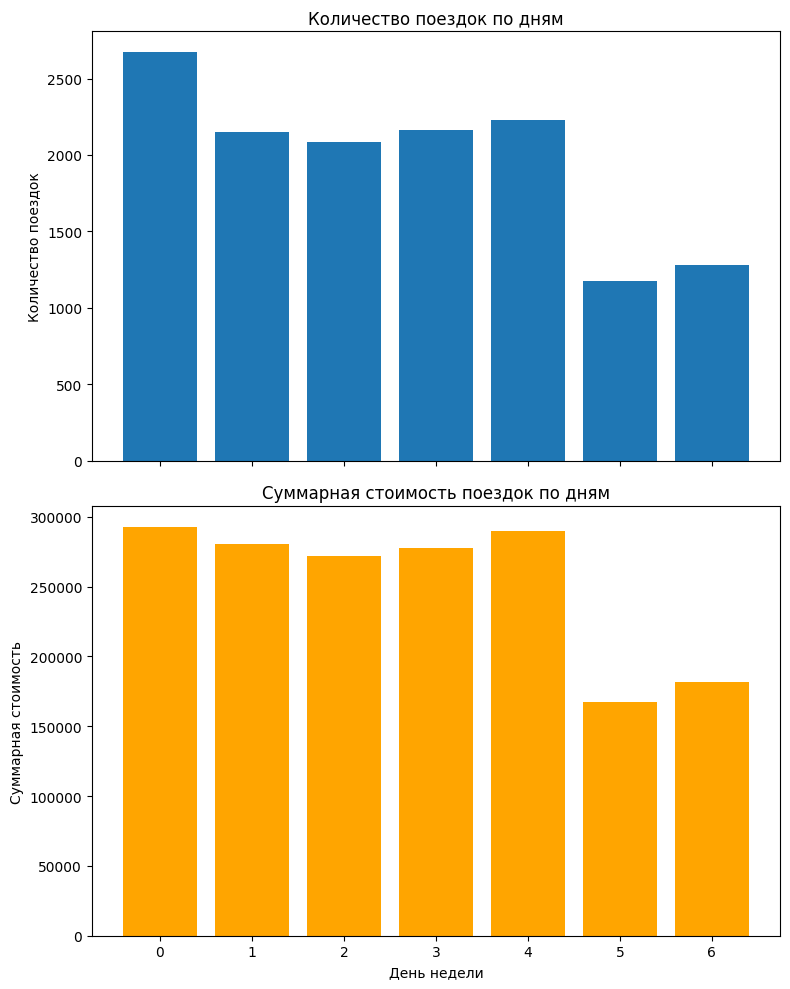

In [69]:
mask = (df['start_date'].dt.time >= pd.Timestamp('06:00:00').time()) & \
       (df['start_date'].dt.time <= pd.Timestamp('10:00:00').time())

rides = df[mask].groupby('weekday').size().reset_index(name='rides_count')
rides_amount = df[mask].groupby('weekday')['cost'].sum().reset_index(name='rides_sum')

df_plot = rides.merge(rides_amount, on='weekday')

fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# 1-й график: количество поездок
axes[0].bar(df_plot['weekday'], df_plot['rides_count'])
axes[0].set_ylabel('Количество поездок')
axes[0].set_title('Количество поездок по дням')

# 2-й график: сумма стоимости
axes[1].bar(df_plot['weekday'], df_plot['rides_sum'], color='orange')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Суммарная стоимость')
axes[1].set_title('Суммарная стоимость поездок по дням')

plt.tight_layout()
plt.show()

# 2. Почасовой трафик

## Почасовой трафик в каждой точке

In [70]:
# Удобно добавить колонку часа и дату для агрегации
df['start_hour'] = df['start_datetime'].dt.floor('h')
df['end_hour'] = df['end_datetime'].dt.floor('h')
df['date'] = df['start_datetime'].dt.date

# 1 Трафик отправлений (departures)
start_traffic = (
    df
    .set_index('start_hour')
    .groupby('start_location')
    .resample('1h')
    .size()
    .reset_index(name='departures')
    .rename(columns={'start_location': 'location', 'start_hour': 'hour'})
)

# 2 Трафик прибытий (arrivals)
end_traffic = (
    df
    .set_index('end_hour')
    .groupby('end_location')
    .resample('1h')
    .size()
    .reset_index(name='arrivals')
    .rename(columns={'end_location': 'location', 'end_hour': 'hour'})
)

# 3 Объединяем arrivals и departures в одну таблицу
traffic = pd.merge(
    start_traffic,
    end_traffic,
    on=['location', 'hour'],
    how='outer'
).fillna(0)

# Добавляем дату начала часа для каждой строки
traffic['date'] = traffic['hour'].dt.date

# 4 Чистый баланс точки (сколько самокатов прибывает или убывает из точки) (arrivals - departures)
traffic['net_flow'] = traffic['arrivals'] - traffic['departures']

# Выводим пример первых 10 строк
print("Пример почасового трафика по точкам")
print(traffic.head(10))

C:\Users\USER\AppData\Local\Temp\ipykernel_32384\2820152644.py:12: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


Пример почасового трафика по точкам
    location                hour  departures  arrivals        date  net_flow
0  Береговая 2023-04-22 10:00:00         0.0       1.0  2023-04-22       1.0
1  Береговая 2023-04-22 11:00:00         0.0       0.0  2023-04-22       0.0
2  Береговая 2023-04-22 12:00:00         0.0       0.0  2023-04-22       0.0
3  Береговая 2023-04-22 13:00:00         1.0       0.0  2023-04-22      -1.0
4  Береговая 2023-04-22 14:00:00         2.0       0.0  2023-04-22      -2.0
5  Береговая 2023-04-22 15:00:00         0.0       0.0  2023-04-22       0.0
6  Береговая 2023-04-22 16:00:00         0.0       0.0  2023-04-22       0.0
7  Береговая 2023-04-22 17:00:00         0.0       1.0  2023-04-22       1.0
8  Береговая 2023-04-22 18:00:00         2.0       1.0  2023-04-22      -1.0
9  Береговая 2023-04-22 19:00:00         0.0       3.0  2023-04-22       3.0


C:\Users\USER\AppData\Local\Temp\ipykernel_32384\2820152644.py:23: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


## Топ-3 точки с самым высоким трафиком

In [71]:
# Суммарный трафик по точкам за весь период
location_traffic = traffic.groupby('location')[['arrivals', 'departures']].sum()
location_traffic['total_traffic'] = location_traffic['arrivals'] + location_traffic['departures']

# Топ-3 по суммарному трафику
top_3_locations = location_traffic.sort_values('total_traffic', ascending=False).head(3)

print("ТОП-3 точки по суммарному трафику")
display(top_3_locations)


# Точки с минимальным трафиком (возможные кандидаты на закрытие)
# Рассчитываем нижние 10% точек по трафику
low_traffic_threshold = location_traffic['total_traffic'].quantile(0.1)
low_traffic_locations = location_traffic[location_traffic['total_traffic'] <= low_traffic_threshold]

print("Точки с минимальным трафиком (нижние 10%)")
display(low_traffic_locations)




ТОП-3 точки по суммарному трафику


,arrivals,departures,total_traffic
location,,,
Луговая,2269.0,2293.0,4562.0
Ломоносова,2246.0,2292.0,4538.0
Спортивная,2313.0,2192.0,4505.0


Точки с минимальным трафиком (нижние 10%)


,arrivals,departures,total_traffic
location,,,
Дружбы,820.0,800.0,1620.0
Железнодорожная,790.0,833.0,1623.0
Куйбышева,778.0,839.0,1617.0
Мира,838.0,779.0,1617.0
Набережная,774.0,793.0,1567.0
Пушкина,708.0,832.0,1540.0
Сиреневая,834.0,795.0,1629.0
Солнечная,804.0,817.0,1621.0
Степная,789.0,811.0,1600.0


## Популярные направления перемещения

In [72]:
popular_routes = (
    df.groupby(['start_location', 'end_location'])
      .size()
      .reset_index(name='rides')
      .sort_values('rides', ascending=False)
)

# Топ-5 маршрутов
top_routes = popular_routes.head(5)
print("Топ-5 популярных направлений перемещения")
display(top_routes)


# 6. Перераспределение самокатов в конце дня
# Суммарный net_flow по каждой точке за день
daily_balance = traffic.groupby(['location', 'date'])['net_flow'].sum().reset_index()

# Средний дневной баланс по точкам
avg_balance = daily_balance.groupby('location')['net_flow'].mean().reset_index().sort_values('net_flow')

print("Средний дневной баланс по точкам")
print(avg_balance)

# Выводы по перераспределению:
print("\nВывод:")
print("Точки с отрицательным net_flow теряют самокаты в течение дня — требуется их перераспределение в конце дня.")
print("Точки с положительным net_flow накапливают самокаты — возможны точки для забора лишних самокатов.")


#Изучить накопительное поведение разницы в трафике в каждой точке (cumsum
#  ). Определить 
# необходимое количество самокатов в каждой точке и в каждом районе для удовлетворения 
# спроса в полном объеме. (Предполагаем, что ежедневно в 6:00 самокаты 
# перераспределяются к исходной позиции

# Сортируем по дате и часу для корректного cumsum
traffic_sorted = traffic.sort_values(['location', 'date', 'hour'])

# Накопительная сумма net_flow по точкам

#cumsum_net_flow = сколько самокатов необходимо иметь в начале дня, чтобы удовлетворять все поездки на данном этапе дня.
#Минимальное значение cumsum_net_flow за день для точки = количество самокатов, которое должно быть в точке в 6:00, чтобы не было дефицита.

traffic_sorted['cumsum_net_flow'] = traffic_sorted.groupby(['location', 'date'])['net_flow'].cumsum()

# Вывод примера
# print("=== Пример накопительного net_flow (cumsum) по точкам ===")
# print(traffic_sorted[['location', 'hour', 'arrivals', 'departures', 'net_flow', 'cumsum_net_flow']].head(15))

# Вычисляем минимальный уровень cumsum_net_flow за день для каждой точки
required_scooters_location = (
    traffic_sorted.groupby(['location', 'date'])['cumsum_net_flow']
    .min()
    .reset_index(name='required_scooters')
)

# Если min < 0, то это количество нужно привезти, чтобы удовлетворить спрос
required_scooters_location['required_scooters'] = required_scooters_location['required_scooters'].apply(lambda x: max(-x, 0))

print()
print("Необходимое количество самокатов в каждой точке (6:00)")
print(required_scooters_location.sort_values('required_scooters', ascending=False).head(10))


# 1. Добавляем net_flow по району (используем start_district)
traffic_sorted['district'] = traffic_sorted['location'].map(df.set_index('start_location')['start_district'].to_dict())

# 2. Группируем по району и дате
required_scooters_district = (
    traffic_sorted.groupby(['district', 'date'])['cumsum_net_flow']
    .min()
    .reset_index(name='required_scooters')
)

required_scooters_district['required_scooters'] = required_scooters_district['required_scooters'].apply(lambda x: max(-x, 0))

print()
print("Необходимое количество самокатов на район (6:00)")
display(required_scooters_district.sort_values('required_scooters', ascending=False).head(10))

Топ-5 популярных направлений перемещения


,start_location,end_location,rides
184,Буденного,Буденного,68
3256,Луговая,Спортивная,67
3347,Майская,Спортивная,61
6586,Спортивная,Майская,60
489,Восточная,Ломоносова,59


Средний дневной баланс по точкам
      location  net_flow
53  Пионерская -1.930693
59     Пушкина -1.227723
77       Труда -0.772277
9       Дачная -0.722772
44    Нагорная -0.722772
..         ...       ...
37   Матросова  0.772277
31      Ленина  0.792079
5    Восточная  0.881188
2    Буденного  0.940594
72  Спортивная  1.198020

[91 rows x 2 columns]

Вывод:
Точки с отрицательным net_flow теряют самокаты в течение дня — требуется их перераспределение в конце дня.
Точки с положительным net_flow накапливают самокаты — возможны точки для забора лишних самокатов.

Необходимое количество самокатов в каждой точке (6:00)
           location        date  required_scooters
3621        Луговая  2023-07-16               26.0
3565        Луговая  2023-05-21               25.0
519       Восточная  2023-05-06               22.0
3714        Майская  2023-07-08               21.0
3728        Майская  2023-07-22               20.0
7322     Спортивная  2023-06-06               18.0
3478     Ломоносов

,district,date,required_scooters
289,Октябрьский,2023-07-16,26.0
233,Октябрьский,2023-05-21,25.0
218,Октябрьский,2023-05-06,22.0
281,Октябрьский,2023-07-08,21.0
295,Октябрьский,2023-07-22,20.0
99,Заречный,2023-07-30,18.0
249,Октябрьский,2023-06-06,18.0
247,Октябрьский,2023-06-04,18.0
57,Заречный,2023-06-18,16.0
369,Северо-Западный,2023-06-25,16.0


# 3. Исследование корреляций

In [73]:
# Создаем временную метку для группировки (округляем до часа)
df_rides['start_hour'] = df_rides['start_date'].dt.floor('h')

# Агрегируем спрос по часам
demand = df_rides.groupby('start_hour').agg({
    'id': 'count',           # количество поездок = СПРОС
    'promo': 'sum',          # сколько поездок с промокодом
    'distance': 'mean',      # средняя дистанция
    'duration': 'mean'       # средняя длительность
}).rename(columns={'id': 'rides_count'})

print("Спрос по часам:", len(demand), "записей")

# Извлекаем временные признаки из индекса
demand['hour'] = demand.index.hour                    # час (0-23)
demand['day_of_week'] = demand.index.dayofweek        # день недели (0=Пн, 6=Вс)
demand['month'] = demand.index.month                  # месяц
demand['day'] = demand.index.day                      # день месяца

# Создаем бинарные признаки
demand['is_weekend'] = (demand['day_of_week'] >= 5).astype(int)  # выходной?
demand['is_monday'] = (demand['day_of_week'] == 0).astype(int)   # понедельник?

# Признак времени промо-акции
demand['is_promo_time'] = (
    (demand['is_monday'] == 1) &
    (demand['hour'] >= 6) &
    (demand['hour'] < 10)
).astype(int)

print("Календарные признаки добавлены")
print(demand[['hour', 'day_of_week', 'is_weekend', 'is_promo_time']].head())

# Объединяем спрос и погоду по времени
df_analysis = demand.merge(
    df_weather,
    left_index=True,        # индекс demand — это start_hour
    right_on='datetime',     # столбец datetime в погоде
    how='inner'             # берем только совпадающие записи
)

print()
print(f"Объединенный датасет: {len(df_analysis)} записей")
print(df_analysis.columns.tolist())

# Определяем группы признаков
weather_features = ['temperature', 'precipitation_total', 'wind_speed',
                    'cloud_cover_total', 'sunshine_duration']
calendar_features = ['hour', 'day_of_week', 'is_weekend', 'is_promo_time']
promo_features = ['promo']

all_features = weather_features + calendar_features + promo_features

# Вычисляем корреляцию каждого признака со спросом
correlations = {}
p_values = {}

for feature in all_features:
    if feature in df_analysis.columns:
        corr, p_val = pearsonr(df_analysis[feature], df_analysis['rides_count'])
        correlations[feature] = corr
        p_values[feature] = p_val

# Создаем таблицу результатов
results = pd.DataFrame({
    'Признак': list(correlations.keys()),
    'Корреляция': list(correlations.values()),
    'P-value': list(p_values.values()),
    'Значимо?': [p < 0.05 for p in p_values.values()]
}).sort_values('Корреляция', key=abs, ascending=False)

print()
print(results)


Спрос по часам: 2415 записей
Календарные признаки добавлены
                     hour  day_of_week  is_weekend  is_promo_time
start_hour                                                       
2023-04-22 09:00:00     9            5           1              0
2023-04-22 10:00:00    10            5           1              0
2023-04-22 11:00:00    11            5           1              0
2023-04-22 12:00:00    12            5           1              0
2023-04-22 13:00:00    13            5           1              0

Объединенный датасет: 2316 записей
['rides_count', 'promo', 'distance', 'duration', 'hour', 'day_of_week', 'month', 'day', 'is_weekend', 'is_monday', 'is_promo_time', 'datetime', 'temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 'cloud_cover_total', 'sunshine_duration']

               Признак  Корреляция        P-value  Значимо?
5                 hour    0.684929  1.576069e-320      True
0          temperature    0.462819  2.683636e-123      True
4    sunsh

## Визуализация

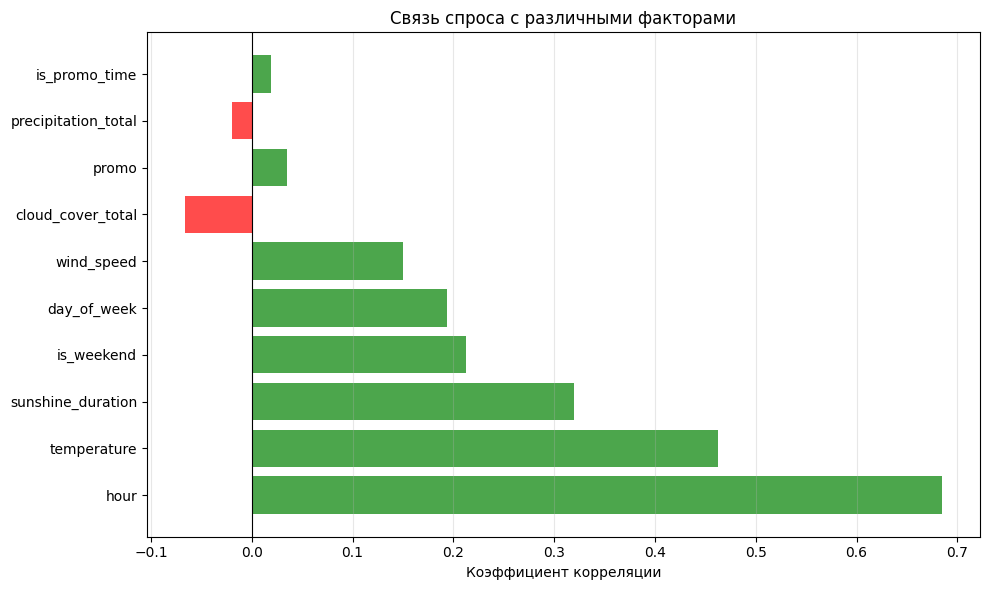

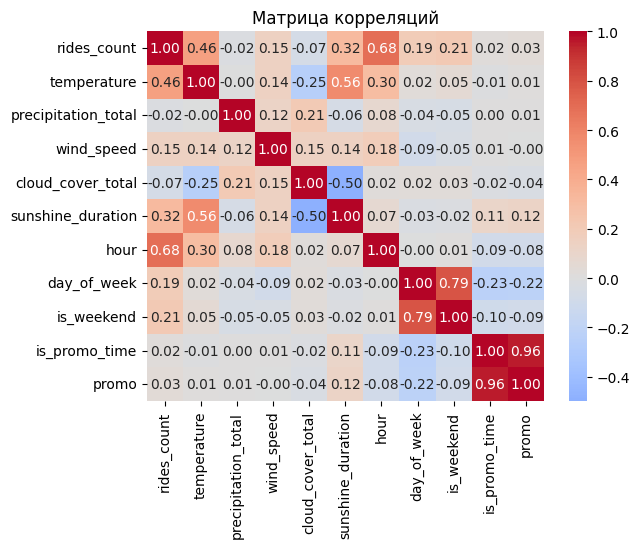

In [74]:
#  График корреляций
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in results['Корреляция']]
plt.barh(results['Признак'], results['Корреляция'], color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Коэффициент корреляции')
plt.title('Связь спроса с различными факторами')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Тепловая карта
correlation_matrix = df_analysis[['rides_count'] + all_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()